In [1]:
import numpy as np
import pandas as pd
import pymupdf
import networkx as nx
from dotenv import load_dotenv
import os

from langchain.text_splitter import CharacterTextSplitter
from langchain_community.graphs import Neo4jGraph
import google.generativeai as genai
from llama_index.embeddings.gemini import GeminiEmbedding

In simple RAG application which the model takes information from PDF, there are some drawbacks to consider:
- **Inefficient database**: The database is list of chunks. When performing semantic search, it has to go through all the chunks in the list. For larger database, this will slow down performance. Beside, the search may go through the chunks that are irrelevant to the question.

- **Searching**: If the desired information is long in the pdf, which need to divide into many chunks. The search may not capture all of the chunks in the information. This leads to fragmented information, making model confused and return untrue data.

In [2]:
# Load env
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
NEO4J_URL = os.getenv('NEO4J_URL')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')

# Graph Build 1

**Graph structure v1**

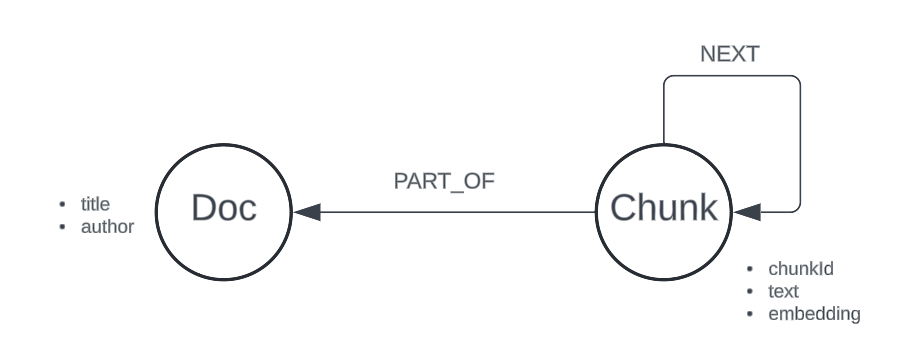

- `Doc`: Document Node containing *title* (name of document) and *author* (author of that document) properties.

- `Chunk`: Chunk Node containing *chunkId*, *text*, and *embedding* (the embedding vector of the chunk).

- The Chunk node has a `PART_OF` relationship to the Doc node, indicating which document the chunk belongs to.

- Each chunk will have a `next` relationship, pointing to the next chunk in document flow (like Linked List) 

## Chunks

In [4]:
# Document: Human Nutrition 2020 by UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM 
##########


# Extract document
file_path = "../doc/Human Nutrition 2020.pdf"

doc = pymupdf.open(file_path)
doc[20].get_text()

'The Benefits of Physical Activity \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \n945 \nFuel Sources \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \n950 \nSports Nutrition \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \n959 \nWater and Electrolyte Needs \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \n972 \nFood Supplements and Food Replacements \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \n977 \nPart\xa0XVII.\xa0Chapter 17. Food Safety \nIntroduction \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \n987 \nThe Major Types of Foodborne Illness \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutri

In [5]:
doc_text = '\n\n'.join([doc[i].get_text() for i in range(2, len(doc))])

In [ ]:
# Create chunk
text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=1500,
    chunk_overlap=200,
)

chunks = text_splitter.split_text(doc_text)

In [8]:
len(chunks)

1020

## Embedding

In [9]:
model_name = "models/embedding-001"

embed_model = GeminiEmbedding(
    model_name=model_name, api_key=GOOGLE_API_KEY
)

result = embed_model.get_text_embedding("Google Gemini Embeddings.")
result[:5], len(result)

([0.04036733, -0.017969217, -0.054796226, 0.004967746, 0.05546861], 768)

In [11]:
# Create list of embedded chunk
embed_chunks = []
count = 0
for chunk in chunks:
    embed_chunks.append(embed_model.get_text_embedding(chunk))
    count += 1
    if count % 100 == 0:
        print("Chunk count: %d" % count)

print("Total embedding chunks: %d" % (len(embed_chunks)))

Chunk count: 100
Chunk count: 200
Chunk count: 300
Chunk count: 400
Chunk count: 500
Chunk count: 600
Chunk count: 700
Chunk count: 800
Chunk count: 900
Chunk count: 1000
Total embedding chunks: 1020


In [12]:
# Save to csv for later use
df = pd.DataFrame({'chunk': chunks, 'embedding': embed_chunks})
df.to_csv('../csv/human_nutrition_2020.csv')
df.head()

,chunk,embedding
0,Human Nutrition: 2020 \nEdition \nUNIVERSITY O...,"[-0.002247958, -0.021488618, -0.036675073, -0...."
1,Lifestyles and Nutrition \nUniversity of Hawai...,"[0.0052474565, 0.00785223, -0.0012310781, -0.0..."
2,The Cardiovascular System \nUniversity of Hawa...,"[-0.008018953, 0.02488508, -0.026663627, -0.01..."
3,"Indicators of Health: Body Mass Index, Body Fa...","[-0.019253992, 0.0036540336, -0.010478293, -0...."
4,Chloride \nUniversity of Hawai‘i at Mānoa Food...,"[-0.0006385167, 0.01877169, -0.04399083, -0.03..."


In [13]:
df = pd.read_csv('../csv/human_nutrition_2020.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,chunk,embedding
0,Human Nutrition: 2020 \nEdition \nUNIVERSITY O...,"[-0.002247958, -0.021488618, -0.036675073, -0...."
1,Lifestyles and Nutrition \nUniversity of Hawai...,"[0.0052474565, 0.00785223, -0.0012310781, -0.0..."
2,The Cardiovascular System \nUniversity of Hawa...,"[-0.008018953, 0.02488508, -0.026663627, -0.01..."
3,"Indicators of Health: Body Mass Index, Body Fa...","[-0.019253992, 0.0036540336, -0.010478293, -0...."
4,Chloride \nUniversity of Hawai‘i at Mānoa Food...,"[-0.0006385167, 0.01877169, -0.04399083, -0.03..."


In [16]:
# Convert dataframe to list of object
data = df.to_dict('records')
print("data format: \n[{'chunk': , 'embedding': }]")

data format: 
[{'chunk': , 'embedding': }]


In [17]:
# Convert embedding value (string) into list of float
for i in range(len(data)):
    data[i]['embedding'] = [float(val) for val in data[i]['embedding'].strip('[]').split(', ')]

## Create Node and relationship

In [18]:
# Cypher query
kg = Neo4jGraph(url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE)

Create Document node

In [13]:
query = """
MERGE (d: Document {docId: "doc-00"})
SET d.title = "Human Nutrition: 2020",
    d.author = "University of Hawai'i at manoa food science and human nutrition program"
"""

kg.query(query)

[]

Create Chunk node

In [16]:
# Create first chunk as head of linked list
query = """
MERGE (c: Chunk {chunkId: "doc-00-chunk-0000"})
SET c.text = $row.chunk
WITH c
CALL db.create.setNodeVectorProperty(c, "embedding", $row.embedding) 

MATCH (d: Document {docId: "doc-00"})
MERGE (c)-[:PART_OF]->(d)
"""

kg.query(query, params={"row": data[0]})

[]

The first node was created. For other chunk, set the previous node point *NEXT* relationship to created node

In [29]:
query = """
MERGE (c: Chunk {chunkId: $chunkId})
SET c.text = $row.chunk
WITH c
CALL db.create.setNodeVectorProperty(c, "embedding", $row.embedding) 

MATCH (d: Document {docId: "doc-00"})
MERGE (c)-[:PART_OF]->(d)
WITH c
MATCH (c1: Chunk {chunkId: $prevChunkId})
MERGE (c1)-[:NEXT]->(c)
"""
node_count = 0
for i in range(1, len(data)):
    chunkId = "doc-00-chunk-" + str(i).zfill(4)
    prevChunkId = "doc-00-chunk-" + str(i - 1).zfill(4)
    
    kg.query(query, params={"chunkId": chunkId, "prevChunkId": prevChunkId, "row": data[i]})

    if (node_count + 1) % 100 == 0:
        print("Node count: %d" % (node_count + 1))

    node_count += 1

print("Total nodes are created: %d" % (node_count + 1)) 

Node count: 100
Node count: 200
Node count: 300
Node count: 400
Node count: 500
Node count: 600
Node count: 700
Node count: 800
Node count: 900
Node count: 1000
Total nodes are created: 1020


In [20]:
# Count number of chunk nodes in database
query = """
MATCH (n:Chunk)
RETURN count(n)
"""

kg.query(query)

[{'count(n)': 1020}]

The relation between nodes in database

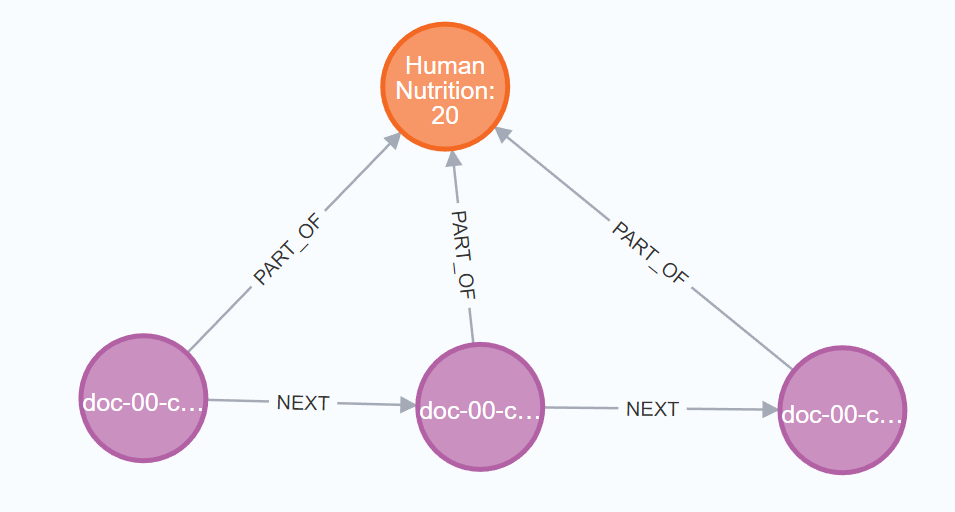

## Create index for search

Create Vector index to search through chunk

In [21]:
query = """
CREATE VECTOR INDEX chunks IF NOT EXISTS
FOR (c: Chunk)
ON c.embedding
OPTIONS {indexConfig: {
    `vector.dimensions`: 768,
    `vector.similarity_function`: 'cosine'
}}
"""

kg.query(query)

[]

Take first chunk and compare with other chunks

In [22]:
# TEST vector search
query = """
MATCH (c: Chunk)
WHERE c.chunkId = "doc-00-chunk-0000"
CALL db.index.vector.queryNodes("chunks", 6, c.embedding)
YIELD node, score
RETURN node.text, score
"""

kg.query(query)

[{'node.text': 'Human Nutrition: 2020 \nEdition \nUNIVERSITY OF HAWAI‘I AT MĀNOA \nFOOD SCIENCE AND HUMAN \nNUTRITION PROGRAM \nALAN TITCHENAL, SKYLAR HARA, \nNOEMI ARCEO CAACBAY, WILLIAM \nMEINKE-LAU, YA-YUN YANG, MARIE \nKAINOA FIALKOWSKI REVILLA, \nJENNIFER DRAPER, GEMADY \nLANGFELDER, CHERYL GIBBY, CHYNA \nNICOLE CHUN, AND ALLISON \nCALABRESE \n\n\nHuman Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program is licensed under a Creative Commons Attribution 4.0 \nInternational License, except where otherwise noted. \n\n\nContents \nPreface \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \nxxv \nAbout the Contributors \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \nxxvi \nAcknowledgements \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \nxl \nPart\xa0I.\xa0Chapter 1

After taking top *k* chunks, the neighboring chunks of those chunks will be retrieved. This will provide more information for the model as well.

In [23]:
# TEST vector search
# We will take the previous chunk (if exists) and next chunk (if exist)
query = """
MATCH (c: Chunk)
WHERE c.chunkId = "doc-00-chunk-0000"
CALL db.index.vector.queryNodes("chunks", 6, c.embedding)
YIELD node, score
RETURN node.text, score, 
[(prev:Chunk)-[:NEXT]->(node) | prev.text] AS prevChunk,
[(node)-[:NEXT]->(next:Chunk) | next.text] AS nextChunk
"""

kg.query(query)[0]

{'node.text': 'Human Nutrition: 2020 \nEdition \nUNIVERSITY OF HAWAI‘I AT MĀNOA \nFOOD SCIENCE AND HUMAN \nNUTRITION PROGRAM \nALAN TITCHENAL, SKYLAR HARA, \nNOEMI ARCEO CAACBAY, WILLIAM \nMEINKE-LAU, YA-YUN YANG, MARIE \nKAINOA FIALKOWSKI REVILLA, \nJENNIFER DRAPER, GEMADY \nLANGFELDER, CHERYL GIBBY, CHYNA \nNICOLE CHUN, AND ALLISON \nCALABRESE \n\n\nHuman Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program is licensed under a Creative Commons Attribution 4.0 \nInternational License, except where otherwise noted. \n\n\nContents \nPreface \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \nxxv \nAbout the Contributors \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \nxxvi \nAcknowledgements \nUniversity of Hawai‘i at Mānoa Food Science and \nHuman Nutrition Program and Human Nutrition \nProgram \nxl \nPart\xa0I.\xa0Chapter 1.

## Test knowledge graph

Perform the search and create generative AI

In [24]:
def create_prompt(query: str, info: list[str]):
    ret = '\n- '
    prompt = f"I have the following information: \n- {ret.join(info)} \
    \nNow, i want you only take those information and answer the following question \
    \n\n{query} \n \
    \nRemember, only take info from information list. \
    \nIf the information list is empty or irrelevant, return 'Can not provide any information'"
    return prompt

In [25]:
print(create_prompt("question", ["info1", "info2"]))

I have the following information: 
- info1
- info2     
Now, i want you only take those information and answer the following question     

question 
     
Remember, only take info from information list.     
If the information list is empty or irrelevant, return 'Can not provide any information'


In [26]:
genai.configure(api_key=GOOGLE_API_KEY)
gen_model = genai.GenerativeModel('gemini-1.0-pro-latest')

In [27]:
question = "Describe the health benefits and health risks \
associated with alcohol consumption "

print(gen_model.generate_content(question).text)

**Health Benefits**

* **Cardiovascular health:** Moderate alcohol consumption (one drink for women, two drinks for men per day) has been associated with a reduced risk of cardiovascular disease, including heart attack and stroke. This benefit is likely due to alcohol's ability to raise HDL ("good") cholesterol and lower LDL ("bad") cholesterol.
* **Diabetes:** Moderate alcohol consumption may also help to reduce the risk of type 2 diabetes. This benefit is likely due to alcohol's ability to improve insulin sensitivity.
* **Weight control:** Moderate alcohol consumption may help to maintain a healthy weight. This benefit is likely due to alcohol's ability to increase metabolism and reduce appetite.
* **Cognitive function:** Moderate alcohol consumption may help to improve cognitive function, including memory and learning. This benefit is likely due to alcohol's ability to increase blood flow to the brain.
* **Stress relief:** Moderate alcohol consumption may help to relieve stress and 

In [28]:
# Test prompt
print(gen_model.generate_content(create_prompt(question, [])).text)

Can not provide any information


Model Test

In [29]:
# Embed the question
print(question)
question_embedding = embed_model.get_text_embedding(question)

print(len(question_embedding))

query = """
CALL db.index.vector.queryNodes("chunks", 10, $question_embedding)
YIELD node, score
RETURN node.text, score, 
[(prev:Chunk)-[:NEXT]->(node) | prev.text] AS prevChunk,
[(node)-[:NEXT]->(next:Chunk) | next.text] AS nextChunk
"""

result = kg.query(query, params={"question_embedding": question_embedding})

info_list = []
# Retrieve information and create prompt
for row in result:
    prev_chunk = row['prevChunk'][0] if len(row['prevChunk']) != 0 else ""
    next_chunk = row['nextChunk'][0] if len(row['nextChunk']) != 0 else ""

    info = prev_chunk + "\n" + row['node.text'] + "\n" + next_chunk
    info_list.append(info)

prompt = create_prompt(question, info_list)

Describe the health benefits and health risks associated with alcohol consumption 
768


In [30]:
print(gen_model.generate_content(prompt).text)

**Health Benefits of Moderate Alcohol Intake**

- Reduces the risk of coronary heart disease by about 30%.
- Reduces the incidences of stroke and heart attack.
- Reduces the risk of death caused by cardiovascular and heart disease.
- Reduces the risk of metabolic syndrome, Type 2 diabetes, and gallstones.
- Serves as a digestive aid, a source of comfort and relaxation, and inducing social interactions.

**Health Risks of Excessive Alcohol Consumption**

- Liver damage, including cirrhosis and liver failure.
- Heart disease, including cardiomyopathy and arrhythmias.
- Stroke.
- Cancer, including oral, esophageal, liver, and breast cancer.
- Pancreatitis.
- Peripheral neuropathy.
- Wernicke-Korsakoff syndrome.
- Fetal alcohol syndrome.


In [32]:
[obj['node.text'][:500] for obj in result]

['Learning Activities \nTechnology Note: The second edition of the Human \nNutrition Open Educational Resource (OER) textbook \nfeatures interactive learning activities.\xa0 These activities are \navailable in the web-based textbook and not available in the \ndownloadable versions (EPUB, Digital PDF, Print_PDF, or \nOpen Document). \nLearning activities may be used across various mobile \ndevices, however, for the best user experience it is strongly \nrecommended that users complete these activities using a \n',
 'Health Risks of Being Overweight and Being \nObese \nThe health consequences of obesity are great and contribute to \nmore than one hundred thousand deaths per year in the United \nStates. According to the CDC, in the United States in 2013-20146: \n• 37.9% of adults age twenty years and over were obese \n• 70.7% of adults age twenty years and over were overweight, \nincluding obese \n• 20.6% of adolescents age twelve to nineteen years were obese \n• 17.4% of children age six 

## Result

> Before prompt:

**Health Benefits**

* **Cardiovascular health:** Moderate alcohol consumption (one drink for women, two drinks for men per day) has been associated with a reduced risk of cardiovascular disease, including heart attack and stroke. This benefit is likely due to alcohol's ability to raise HDL ("good") cholesterol and lower LDL ("bad") cholesterol.
* **Diabetes:** Moderate alcohol consumption may also help to reduce the risk of type 2 diabetes. This benefit is likely due to alcohol's ability to improve insulin sensitivity.
* **Weight control:** Moderate alcohol consumption may help to maintain a healthy weight. This benefit is likely due to alcohol's ability to increase metabolism and reduce appetite.
* **Cognitive function:** Moderate alcohol consumption may help to improve cognitive function, including memory and learning. This benefit is likely due to alcohol's ability to increase blood flow to the brain.
* **Stress relief:** Moderate alcohol consumption may help to relieve stress and anxiety. This benefit is likely due to alcohol's ability to activate the GABA neurotransmitter system, which has calming effects.

**Health Risks**

* **Liver damage:** Excessive alcohol consumption can damage the liver, leading to cirrhosis and liver failure.
* **Heart disease:** Excessive alcohol consumption can also increase the risk of heart disease, including heart attack and stroke. This risk is especially high for people who are overweight or have high blood pressure.
* **Cancer:** Excessive alcohol consumption is associated with an increased risk of several types of cancer, including oral, esophageal, and breast cancer.
* **Stroke:** Excessive alcohol consumption can increase the risk of stroke. This risk is especially high for people who are overweight or have high blood pressure.
* **Brain damage:** Excessive alcohol consumption can damage the brain, leading to cognitive impairment, memory loss, and dementia.
* **Mental health problems:** Excessive alcohol consumption can increase the risk of mental health problems, including depression and anxiety.
* **Social problems:** Excessive alcohol consumption can lead to social problems, such as relationship problems, job loss, and financial problems.

<br>
<br>

> After prompt:


**Health Benefits of Moderate Alcohol Intake**

- Reduces the risk of coronary heart disease by about 30%.
- Reduces the incidences of stroke and heart attack.
- Reduces the risk of death caused by cardiovascular and heart disease.
- Reduces the risk of metabolic syndrome, Type 2 diabetes, and gallstones.
- Serves as a digestive aid, a source of comfort and relaxation, and inducing social interactions.

**Health Risks of Excessive Alcohol Consumption**

- Liver damage, including cirrhosis and liver failure.
- Heart disease, including cardiomyopathy and arrhythmias.
- Stroke.
- Cancer, including oral, esophageal, liver, and breast cancer.
- Pancreatitis.
- Peripheral neuropathy.
- Wernicke-Korsakoff syndrome.
- Fetal alcohol syndrome.

<br><br>

> **Result Analysis**:

Comparing to the result the model provided without knowledge graph, the knowledge graph has provided more detailed data about the benefit and risk when using alcohol. With the used of linked list structure, more information can be captured by getting the neighboring chunks of top score chunks.

However, in the top score chunks, some of the chunks are irrelevant to the question. For instance: the 3rd chunk does not provide any useful information, its high score can be due to the appearance of word 'benefit'.

<br><br>

> **Performance**:

In order to search for information, the model processed 1020 nodes in the index table. Beside, not all retrieval nodes were irrelevant to the question. <br> For larger database that may contain information, chunks from different categories, going through all the chunks is efficient in term of both performance and accuracy.